## Requirements 

In [7]:
#!pip install rdkit-pypi
#!pip install mordred
#!pip install tqdm

## 1. Data collection and cleaning

The first step when building a model is to collect the data that we need to train our model on.

Dataset source : https://www.researchgate.net/publication/289528451_Jean-Claude_Bradley_Open_Melting_Point_Dataset


In [19]:
# Needed libraries
import pathlib
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np 
from rdkit import Chem
from tqdm import tqdm
import time
import sys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
sys.path.append('../')
from moleculAR.moleculAR.preprocessing import smiles_cleaning as sc
from rdkit.Chem import rdMolDescriptors, MACCSkeys, RDKFingerprint, Descriptors
from moleculAR.moleculAR.preprocessing import featurization
from moleculAR.moleculAR.training import regression_models as rm
from moleculAR.moleculAR.preprocessing import feature_cleaning as fc
from rdkit import RDLogger


In [20]:
# Set the data path and import the dataset
experimental_data_path = pathlib.Path("../data/BradleyMeltingPointDataset.xlsx")
raw_df = pd.read_excel(experimental_data_path)
raw_df.shape

(28645, 9)

In [21]:
raw_df.head(5)

,key,name,smiles,mpC,csid,link,source,donotuse,donotusebecause
0,1,"2-(2,4-dinitrobenzyl)pyridine",c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,64018,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192,Alfa Aesar,NaN,NaN
1,2,2-(1-piperidinyl)aniline,c1ccc(c(c1)N)N2CCCCC2,46.0,403764,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073,Alfa Aesar,NaN,NaN
2,3,2-(1-piperazinyl)pyrimidine,c1cnc(nc1)N2CCNCC2,33.0,80080,http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884,Alfa Aesar,NaN,NaN
3,4,2-(1-piperazinyl)phenol,c1ccc(c(c1)N2CCNCC2)O,125.0,63701,http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252,Alfa Aesar,NaN,NaN
4,5,2-(1-cyclohexenyl)ethylamine,C1CCC(=CC1)CCN,-55.0,69388,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261,Alfa Aesar,NaN,NaN


As the dataset contains "donotuse" marker for data that are proven to be wrong, we will delete all row with a "donotuse" marker :

In [22]:
df = raw_df[raw_df['donotuse'].isnull()]
df.shape

(28268, 9)

Now, we ensure that the dataset do not contains impossible, non-canonical, or duplicate smiles :

In [23]:
RDLogger.DisableLog('rdApp.error') # Disable error messages from invalid SMILES
unique_df = sc.clean_smiles_dataframe(df, "smiles")
RDLogger.EnableLog('rdApp.error') # Enable error messages back
print(f"The new dataframe has {unique_df.shape[0]} unique SMILES")


Removed 8323 rows with invalid or duplicate SMILES.
The new dataframe has 19945 unique SMILES


Finally, we only need the smiles and melting point (Celsius) columns :

In [24]:
final_dataset = unique_df[['smiles', 'mpC']]
final_dataset.shape

(19945, 2)

## Data Analysis

Before generating features and train the model, we can analyze our data. We can verify if expected trends are observed. For example, we know that H-bond abilities have a significant impact on melting point, let see an histogram of melting point with and without H-bond-able molecules.

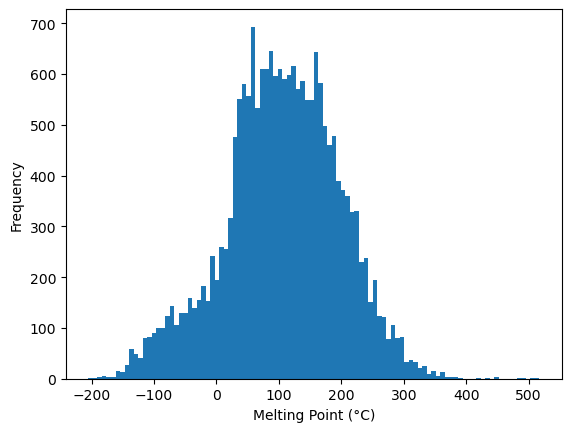

Average melting point: 105.2089275507646


In [7]:
# See the distribution of the melting points
plt.hist(final_dataset['mpC'], bins=100)
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# Print the average melting point
print(f"Average melting point: {final_dataset['mpC'].mean()}")


Now, let's see how it looks without Hbond molecules. We could calculate the HbondDonnor and HbondAcceptor descriptor to be more accurate, but we will here remove all molecules containing O, N, F, Cl atoms with the remove_unwanted_atoms function.

In [8]:
no_Hbond_df = sc.remove_unwanted_atoms(final_dataset, ['O', 'N', 'F'], "smiles")

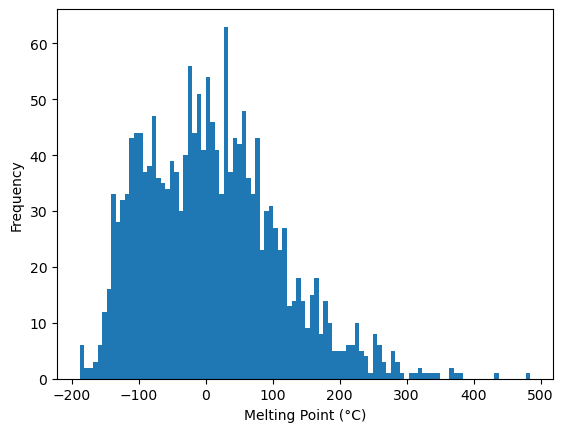

Average melting point: 9.784016949152543


In [9]:
# See the distribution of the melting points
plt.hist(no_Hbond_df['mpC'], bins=100)
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# Print the average melting point
print(f"Average melting point: {no_Hbond_df['mpC'].mean()}")

As expected, compound with no H-bond abilities have a much lower melting point.

We will use features for the training. It can be rdkit/mordred descriptors, or different types of fingerprint. Let's analyze how the rdkit descriptors correlate with the melting point.<br>
<br>
The following function has already been run and the results are in the data files, we can simply load them :

In [10]:
"""
# Calculate the RDKit descriptors
df_descriptors = featurization.RDkit_descriptors(final_dataset, 'smiles')

#Save the results in a csv file
df_descriptors.to_csv('../data/200rdkit_desc.csv', index=False)
"""
# Load the RDKit descriptors dataset
df_descriptors = pd.read_csv('../data/200rdkit_desc.csv')

In [11]:
df_descriptors.head(5)

,smiles,mpC,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,10.949337,-0.655211,10.949337,0.259075,0.619888,259.221,250.149,259.059306,...,0,0,0,0,0,0,0,0,0,0
1,c1ccc(c(c1)N)N2CCCCC2,46.0,5.909724,0.906852,5.909724,0.906852,0.664933,176.263,160.135,176.131349,...,0,0,0,0,0,0,0,0,0,0
2,c1cnc(nc1)N2CCNCC2,33.0,4.189444,0.846296,4.189444,0.846296,0.628312,164.212,152.116,164.106196,...,0,0,0,0,0,0,0,0,0,0
3,c1ccc(c(c1)N2CCNCC2)O,125.0,9.600688,0.379074,9.600688,0.379074,0.667456,178.235,164.123,178.110613,...,0,0,0,0,0,0,0,0,0,0
4,C1CCC(=CC1)CCN,-55.0,5.418520,0.825231,5.418520,0.825231,0.559754,125.215,110.095,125.120449,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Display the top 3 descriptors correlated with the melting point
features = df_descriptors.drop(columns=['smiles', 'mpC'])
target = df_descriptors['mpC']
correlation = features.corrwith(target)
correlation = correlation.abs().sort_values(ascending=False)
correlation.head(3)

BertzCT      0.568399
RingCount    0.533590
TPSA         0.522911
dtype: float64

The 3 most correlated descriptors are BertzCT, RingCount and TPSA. Let's plot plot the melting point as a function BertzCT wich is continuous and the RingCount wich is discret.

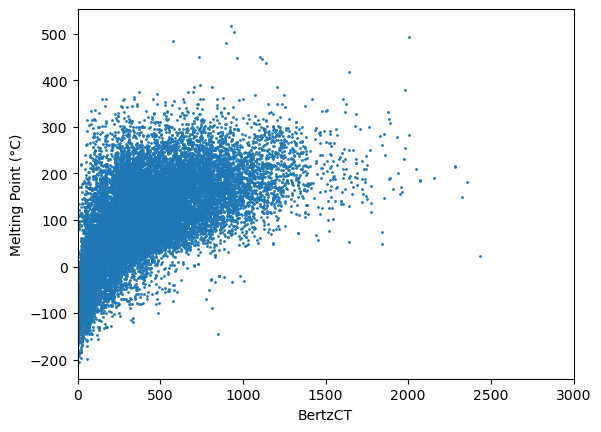

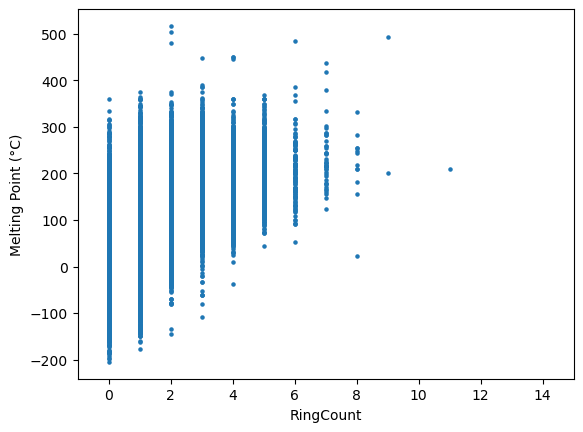

In [13]:
# Plot BertzCT vs Melting Point
plt.scatter(df_descriptors['BertzCT'], df_descriptors['mpC'], s=1)
plt.xlabel('BertzCT')
# Range of the x-axis
plt.xlim(0, 3000)
plt.ylabel('Melting Point (°C)')
plt.show()

# Plot RingCount vs Melting Point
plt.scatter(df_descriptors['RingCount'], df_descriptors['mpC'], s=5)
plt.xlabel('RingCount')
plt.xlim(-1, 15)
plt.ylabel('Melting Point (°C)')
plt.show()

Here we identify another expected trend : the melting point tends to rise with the ring count. Even more, the ring count seems to define a range of possible value for the melting point.

## Featurization

In order to train a model, we need features for each smiles. With the MoleculAR package, we have here 2 main choices :
- Descriptors : mordred or rdkit
- Fingerprints : Morgan, MACCS, Topological

Here, we will only try all type of fingerprint and only rdkit descriptors because generate mordred descriptors is computationally very demanding as there is more than 1800 different descriptors. 

In [25]:
# We already have the dataset with the RDKit descriptors from the previous step
rdkit_desc = pd.read_csv('../data/200rdkit_desc.csv')

# Generate the 3 types of fingerprints
morgan_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='Morgan', n_bits=2048)
maccs_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='MACCS', n_bits=2048)
topo_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='Topological', n_bits=2048)

We can define our features(X) and target(y) for the training :

In [26]:
# Separe mpC and smiles from datasets
y = final_dataset['mpC']
# Drop the mpC and smiles columns to only keep the features
X_rdkit = rdkit_desc.drop(columns=['smiles', 'mpC'])
X_morgan_fgp = morgan_fgp.drop(columns=['smiles', 'mpC'])
X_maccs_fgp = maccs_fgp.drop(columns=['smiles', 'mpC'])
X_topo_fgp = topo_fgp.drop(columns=['smiles', 'mpC'])

Now we have to look if one of the feature dataset conatins NaN values, this can cause trouble for the model training

In [28]:
# See if the datasets have NaN values
print(f"rdkit_desc as {X_rdkit.isna().sum().sum()} NaN values")
print(f"X_morgan_fgp as {X_morgan_fgp.isna().sum().sum()} NaN values")
print(f"X_maccs_fgp as {X_maccs_fgp.isna().sum().sum()} NaN values")
print(f"X_topo_fgp as {X_topo_fgp.isna().sum().sum()} NaN values")

rdkit_desc as 72 NaN values
X_morgan_fgp as 0 NaN values
X_maccs_fgp as 0 NaN values
X_topo_fgp as 0 NaN values


We see that the rdkit_desc contains NaN values. There's many different ways to handle NaN values in machine learning, here we will use the handle_missing_data function with a threshold of 0.8 and the fill method "mean".

In [29]:
X_rdkit = fc.handle_missing_data(X_rdkit, threshold=0.8, fill_method="mean")

## Model training

In [32]:
rm.compare_regression_models(X_morgan_fgp, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 15956, number of used features: 2004
[LightGBM] [Info] Start training from score 105.178100


,R2 Score,RMSE
XGBoost,0.709673,49.402233
Random Forest,0.704038,49.879322
LightGBM,0.694995,50.635638
Linear Regression,0.619239,56.575597
Gradient Boosting,0.592861,58.502505


In [56]:
rm.compare_regression_models(X_rdkit, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23929
[LightGBM] [Info] Number of data points in the train set: 15956, number of used features: 197
[LightGBM] [Info] Start training from score 105.178100


,R2 Score,RMSE
XGBoost,0.806190,40.363691
LightGBM,0.800634,40.938191
Random Forest,0.796876,41.322212
Gradient Boosting,0.750904,45.760044
Linear Regression,0.708182,49.528918


In [61]:
rm.compare_regression_models(X_morgan_fgp, y, models=['Random Forest', 'LightGBM'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 15956, number of used features: 2004
[LightGBM] [Info] Start training from score 105.178100


,R2 Score,RMSE
Random Forest,0.703603,49.916017
LightGBM,0.694995,50.635638


In [31]:
rm.compare_regression_models(X_topo_fgp, y, models=['LightGBM', 'Gradient Boosting' ])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 15956, number of used features: 2048
[LightGBM] [Info] Start training from score 105.178100


,R2 Score,RMSE
LightGBM,0.691794,50.900690
Gradient Boosting,0.588845,58.790288


R² Score: 0.7951
RMSE: 41.8031


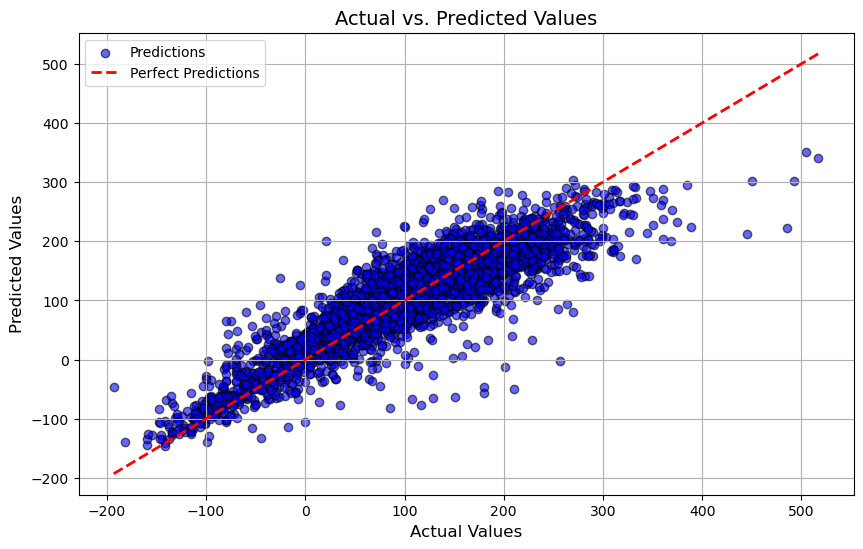

In [62]:
from sklearn.ensemble import RandomForestRegressor
rm.plot_predictions(RandomForestRegressor(), X_rdkit, y, test_size=0.2, random_state = 42)